## init

In [12]:
import json
import os
import copy
import random

from torch import nn
import torch
import numpy as np
import pandas as pd
import h5py
import tqdm
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import concurrent
import concurrent.futures
from tqdm import tqdm
from collections import Counter
import decord
import cv2

from mllm.tools.extract_verb_sentence import VocabularyFilter
from mllm.dataset.utils import save_to_json, save_to_jsonl, read_json_file, read_jsonl_file, read_txt_file

def get_video_duration(video_path, loader_type = 'decord'):
    if loader_type == 'decord':
        vr = decord.VideoReader(video_path)
        vlen = len(vr)
        fps = vr.get_avg_fps()
        duration = float(vlen / fps)
        vr = None  # 这会导致VideoReader对象被垃圾回收，释放资源
        return duration
    elif loader_type == 'opencv':
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError("Could not open the video: ", video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = float(total_frames) / fps
        cap.release()

        return duration
    
def match_file_with_basename(directory, basename):
    for filename in os.listdir(directory):
        if filename.startswith(basename) and os.path.isfile(os.path.join(directory, filename)):
            return filename
    
def reoganize_std_jsonl(std_data: list)->list:
    videos = []
    tree_std_data_list = []
    
    for i in tqdm(std_data): # i为原始数据
        if i['video'] not in videos: # 当前没有视频，初始化
            tree_std_data = {}
            tree_std_data['captions'] = []
            tree_std_data['timestamps'] = []
            videos.append(i['video'])
            tree_std_data['video'] = i['video']
            tree_std_data['duration'] = i['duration']
            tree_std_data['source'] = i['source']
            tree_std_data['clip'] = i['clip']
            tree_std_data['captions'].append(i['captions'])
            tree_std_data['timestamps'].append(i['timestamps'])
            tree_std_data_list.append(tree_std_data)
        else: # 有视频
            tree_std_data = tree_std_data_list[videos.index(i['video'])]
            if i['captions'] not in tree_std_data['captions']: # 没有相同caption
                tree_std_data['captions'].append(i['captions'])
                tree_std_data['timestamps'].append(i['timestamps'])
            else: # 有相同caption
                timestamps_idx = tree_std_data['captions'].index(i['captions'])
                tree_std_data['timestamps'][timestamps_idx].append(i['timestamps'])
            
                        
    return tree_std_data_list

vocabfilter = VocabularyFilter()

# IternVid-Action

In [ ]:
# filter verb 13h
internvid = '/share_ssd/tianjirui/InterVid-FLT/InternVid-10M-flt.jsonl'
it = read_jsonl_file(internvid)

it_act_videos = set()
it_act = []        

for i in it: # 14h
    if vocabfilter.match_pattern(i['Caption']):
        it_act.append(i)
        it_act_videos.add(i['YoutubeID'])
        
save_to_jsonl(it_act, '/share_ssd/tianjirui/InterVid-FLT/IternVid-Act/InternVid-Act-Matcher.jsonl')



print("captions:", len(it_act)) # 7,579,303
print("videos:", len(it_act_videos)) # 3,504,360


In [ ]:
# get youtube video length, filter video length
it_verb = read_jsonl_file('/share_ssd/tianjirui/InterVid-FLT/IternVid-Act/InternVid-Act-Matcher.jsonl')

for i in it_verb:
    id = i['YoutubeID'] # 还没写
    

In [3]:
# filter by time length and proportion of action  5h
def filter_proportion(verb_entry):
    st = verb_entry["Start_timestamp"]
    ed = verb_entry["End_timestamp"]

    st_h, st_m, st_s = map(float, st.split(':'))
    st = st_h*3600 + st_m*60 + st_s
    ed_h, ed_m, ed_s = map(float, ed.split(':'))
    ed = ed_h*3600 + ed_m*60 + ed_s

    duration = ed - st

    if duration > duration_threshold and ed < p*duration and ed < ed_threshold :
        return verb_entry
    return None

it_verb = read_jsonl_file('/share_ssd/tianjirui/InterVid-FLT/IternVid-Act/InternVid-Act-Matcher.jsonl')
duration_threshold = 9 # 大于3秒
ed_threshold = 3*60 # 3分钟内
proportion_threshold = 0.01
p = 1/proportion_threshold
num_threads = 4  # 根据你的系统资源调整线程数

it_act_videos = set()

with ThreadPoolExecutor(max_workers=num_threads) as executor: # 多线程
    futures = [executor.submit(filter_proportion, verb_entry) for verb_entry in tqdm(it_verb)]
    it_act_proportion = [future.result() for future in futures if future.result() is not None] # 合并异步的结果

# 现在it_verb包含了所有条目，我们需要手动计算剩余条目
print("captions:", len(it_act_proportion))  # 1,091,775 
print("videos:", len([it_act_videos.add(i["YoutubeID"]) for i in it_act_proportion])) # 1,091,775

'''
# 此处筛选了标注持续时长超过9秒的视频，并且ed的数值不超过3分钟，总数1091775
# （此处暂时搁置，待使用小数据集验证后再继续）
# 下一步预计随机选取其中约150k的视频，并回到最初的大文件中将每个视频对应的字幕提取出来，统一到一个jsonl的文件中
# 然后再将这个文件中的字幕进行预处理，预计使用bert计算语义之间的相似度，然后将相似度高的字幕进行合并，
# 然后找合适的网络进行下载视频，根据视频中字幕的占比再进行一次筛选

'''

save_to_jsonl(it_verb, '/share_ssd/tianjirui/InterVid-FLT/IternVid-Act/InternVid-Act-Proportion-Length-3s.jsonl')

100%|██████████| 7579303/7579303 [05:13<00:00, 24202.84it/s] 


captions: 1091775
videos: 1091775
Data saved as JSONL file: /share_ssd/tianjirui/InterVid-FLT/IternVid-Act/InternVid-Act-Proportion-Length-3s.jsonl


## IternVid-G

In [5]:
iternvidg = '/share_ssd/tianjirui/InterVid-FLT/IternVid-G/val.jsonl'
it_g = read_jsonl_file(iternvidg)

# for it_g_obj in it_g:
#     if it_g_obj['video'].split('.')[0] == 'DLCTKmwCeaI':
#         print(it_g_obj)

print(it_g[0])

pass

{'video': '154xLGU5KoU.mp4', 'duration': 210.047656, 'start_sec': 114.967, 'end_sec': 119.967, 'neg_start_sec': 109.967, 'neg_end_sec': 124.967, 'caption': 'a girl in a baseball cap with a chinese character', 'start_scene': 23, 'end_scene': 23, 'neg_start_scene': 21, 'neg_end_scene': 25}


In [8]:
# EDA

# 1. video num
videos = set()
filter_it_g = []

for it_g_obj in tqdm(it_g): # 60 min
    videos.add(it_g_obj['video'])
    
    if vocabfilter.match_pattern(it_g_obj['caption']):
        filter_it_g.append(it_g_obj)
    
    
videos_num = len(videos) # 83025 videos
it_g_caption_num = len(it_g) # 715k caption





In [10]:
# save filter_it_g

save_to_jsonl(filter_it_g, '/share_ssd/tianjirui/InterVid-FLT/IternVid-G/verb_and_direction_sub/train_filter.jsonl')
# 71k videos, 509 captions

Data saved as JSONL file: /share_ssd/tianjirui/InterVid-FLT/IternVid-G/verb_and_direction_sub/train_filter.jsonl


# InternVid-G verb and direction sub

In [2]:
iternvidg_sub = '/share_ssd/tianjirui/InterVid-FLT/IternVid-G/verb_and_direction_sub/train_filter.jsonl'
it_g_sub = read_jsonl_file(iternvidg_sub)

filter_videos = set()
for f_it_g_obj in it_g_sub:
    filter_videos.add(f_it_g_obj['video'])
    
filter_videos_num = len(filter_videos) #  71697 videos
filter_caption_num = len(it_g_sub) #  509517 caption

print('filter_videos_num:', filter_videos_num)
print('filter_caption_num:', filter_caption_num)

pass


filter_videos_num: 71697
filter_caption_num: 509517


filter_videos_num: 33031
filter_caption_num: 107278


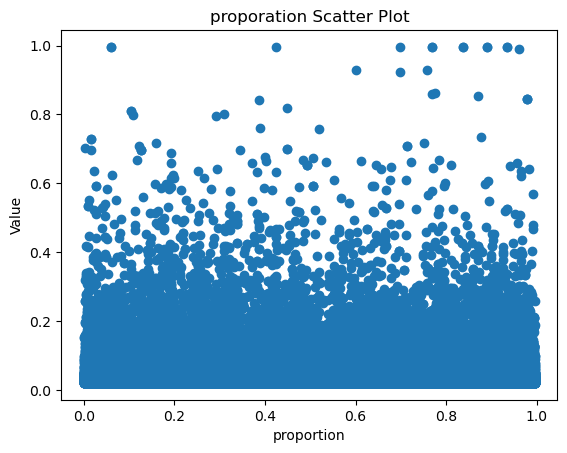

In [14]:
# filter caption proportion
proporation_list = []
proporation_thres = 0.02
it_g_sub_p = []

proporation_video = set()
for f_it_g_obj in it_g_sub:
    duration = float(f_it_g_obj['duration'])
    start_sec = float(f_it_g_obj['start_sec'])
    end_sec = float(f_it_g_obj['end_sec'])
    proporation = (end_sec - start_sec) / duration
    
    if proporation > proporation_thres:
        proporation_list.append(proporation)
        it_g_sub_p.append(f_it_g_obj)

for f_it_g_obj in it_g_sub_p:
    proporation_video.add(f_it_g_obj['video'])
    
print('filter_videos_num:', len(proporation_video))
print('filter_caption_num:', len(proporation_list))
    
# EDA
# x_axis = list(range(0, int(np.ceil(max(proporation_list)))))
x_axis = np.linspace(0, max(proporation_list), len(proporation_list))


plt.scatter(x_axis, proporation_list)
plt.title('proporation Scatter Plot')
plt.xlabel('proportion')
plt.ylabel('Value')
plt.show()

## VTimeLLM-stage2

In [ ]:
vtimellm_s2 = '/share_ssd/tianjirui/InterVid-FLT/VTimeLLM-sub/stage2.json'
vt_s2 = read_jsonl_file(vtimellm_s2)

vt_s2_conv_num = len(vt_s2) # 146k
# vt_s2_caption_num # 353k

pass

In [9]:
# feat

vt_s2_feat = '/home/tianjirui/VTimeLLM/feat/intern_clip_feat/__1XYrUQ0E0.npy'
vt_s2_feat = torch.from_numpy(np.load(vt_s2_feat)).float()
vt_s2_feat.shape # 100,768

pass

## DiDeMo

In [18]:
# feature files
didemo_rgb_feats_path = '/share_ssd/tianjirui/DiDeMo/LocalizingMoments/average_rgb_feats.h5'
with h5py.File(didemo_rgb_feats_path, mode='r') as h5_file:
    for key in h5_file.keys():
        print(h5_file[key].name)
        print(h5_file[key].shape)
        print(key)
        
        
    h5_file.close()
pass


/10015567@N08_3655084291_d8b58466fa.mov
(6, 4096)
10015567@N08_3655084291_d8b58466fa.mov
/100233434@N08_9622921646_c39ac10ea3.mp4
(6, 4096)
100233434@N08_9622921646_c39ac10ea3.mp4
/100233434@N08_9815525316_b919341a87.mp4
(6, 4096)
100233434@N08_9815525316_b919341a87.mp4
/100233434@N08_9818651914_0cb3c42868.mp4
(6, 4096)
100233434@N08_9818651914_0cb3c42868.mp4
/10052357@N03_7585070382_5762149bfc.
(6, 4096)
10052357@N03_7585070382_5762149bfc.
/101042541@N03_9670495147_376d39fbc8.mp4
(6, 4096)
101042541@N03_9670495147_376d39fbc8.mp4
/10117647@N06_5972369924_ea1dc29d2a.mp4
(6, 4096)
10117647@N06_5972369924_ea1dc29d2a.mp4
/10137764@N00_5773495263_d59cf296fb.3gp
(6, 4096)
10137764@N00_5773495263_d59cf296fb.3gp
/10149286@N00_5135045216_643d0b0a92.mov
(6, 4096)
10149286@N00_5135045216_643d0b0a92.mov
/10167516@N04_2414874691_c569ebc783.mpg
(6, 4096)
10167516@N04_2414874691_c569ebc783.mpg
/10173345@N04_2468236062_d48a76db7e.mov
(6, 4096)
10173345@N04_2468236062_d48a76db7e.mov
/10175347@N00_48415

In [16]:
# rename videos(because windows can't end with ".")
didemo_video_path = '/share_ssd/tianjirui/DiDeMo/videos'

for root, dirs, files in os.walk(didemo_video_path):
    for file in files:
        if '.' not in file:
            os.rename(os.path.join(root, file), os.path.join(root, file + '.'))

In [2]:
# init

didemo_video_path = '/share_ssd/tianjirui/DiDeMo/videos'
didemo_json_train_path = '/share_ssd/tianjirui/DiDeMo/data/train_data.json'
didemo_json_val_path = '/share_ssd/tianjirui/DiDeMo/data/val_data.json'
didemo_json_test_path = '/share_ssd/tianjirui/DiDeMo/data/test_data.json'

dd_train = read_json_file(didemo_json_train_path)
dd_val = read_json_file(didemo_json_val_path)
dd_test = read_json_file(didemo_json_test_path)

idx = 30
print(dd_train[idx])
print(dd_val[idx])
print(dd_test[idx])

tuple_lst = [tuple(sublist) for sublist in dd_train[idx]['times']]
# test_lst = [(5, 5), (3, 5), (3, 5), (4, 5)]
counter =Counter(tuple_lst)
print(list(counter.most_common(1)[0][0]))



pass

{'num_segments': 6, 'description': 'the musician sets his music stand down', 'dl_link': 'https://www.flickr.com/video_download.gne?id=3902581172', 'times': [[4, 4], [4, 4], [4, 4], [5, 5]], 'video': '39787674@N00_3902581172_957490ae17.avi', 'annotation_id': 57}
{'num_segments': 5, 'description': 'a man and a boy are playing by banners.', 'dl_link': 'https://www.flickr.com/video_download.gne?id=7473367592', 'times': [[2, 4], [3, 4], [3, 3], [3, 4]], 'video': '45909111@N00_7473367592_914f84e5a7.avi', 'annotation_id': 18278}
{'num_segments': 6, 'description': 'the baby in green first appears to nod once', 'dl_link': 'https://www.flickr.com/video_download.gne?id=3975028282', 'times': [[0, 0], [0, 0], [0, 0], [0, 0]], 'video': '66579708@N00_3975028282_b02e8ebfa1.avi', 'annotation_id': 50467}
[4, 4]


In [5]:
# for error videos
didemo_video_train_root = r'/share_ssd/tianjirui/DiDeMo/videos/train_videos'
error_videos = []
def check_error_video(i):
    try:
        vid_path = os.path.join(didemo_video_train_root, i['video'])
        duration = get_video_duration(vid_path, loader_type='opencv')
    except:
        error_videos.append(i)

with ThreadPoolExecutor(max_workers=4) as executor: # 多线程
    futures = [executor.submit(check_error_video, i) for i in tqdm(dd_train)]
    # error_videos = [future.result() for future in futures if future.result() is not None]
    
        
save_to_jsonl(error_videos, '/share_ssd/tianjirui/DiDeMo/data/error_videos.jsonl')
            

100%|██████████| 33005/33005 [00:01<00:00, 28200.26it/s]
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b3c0012c0] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b3018b6c0] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b30075840] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b384e3f40] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b30075840] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b341e1380] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b30075840] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b3c10a300] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b381d3140] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b381c5ac0] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b341e1380] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7b4b341e1380] Reference

Data saved as JSONL file: /share_ssd/tianjirui/DiDeMo/data/error_videos.jsonl


In [10]:
# standardize
def get_mode_and_to_sec(lst, duration): # 取众数
    tuple_lst = [tuple(sublist) for sublist in lst]
    counter = Counter(tuple_lst)
    timestamp = list(counter.most_common(1)[0][0])
    timestamp = [timestamp[0]*5., min((timestamp[1]+1)*5., duration)]
    return timestamp

didemo_video_train_root = r'/share_ssd/tianjirui/DiDeMo/videos/train_videos'
didemo_video_val_root = r'/share_ssd/tianjirui/DiDeMo/videos/val_videos'
didemo_video_test_root = r'/share_ssd/tianjirui/DiDeMo/videos/test_videos'


def standardize_didemo(i, root):
    dd_std = {}
    dd_std['video'] = i['video']
    vid_path = os.path.join(root, i['video'])
    dd_std['duration'] = get_video_duration(vid_path, loader_type='opencv')
    dd_std['source'] = 'didemo'
    dd_std['clip'] = [0., min(30., dd_std['duration'])]
    dd_std['captions'] = i['description']
    timestamp = get_mode_and_to_sec(i['times'], dd_std['duration'])
    dd_std['timestamps'] = [timestamp]
    return dd_std

    
### 此处测试集和验证集计算原仓库是与标签逐个计算取平均值，此处仅使用众数，可能略有出入
dd_std_train_list = [standardize_didemo(i, didemo_video_train_root) for i in tqdm(dd_train)]
save_to_jsonl(dd_std_train_list, 'data/orig/didemo_train.jsonl')
# dd_tree_train_list = reoganize_std_jsonl(dd_std_train_list)
# save_to_jsonl(dd_tree_train_list, 'data/didemo_train_tree.jsonl')

dd_std_val_list = [standardize_didemo(i, didemo_video_val_root) for i in tqdm(dd_val)]
save_to_jsonl(dd_std_val_list, 'data/orig/didemo_val.jsonl')
# dd_tree_val_list = reoganize_std_jsonl(dd_std_val_list)
# save_to_jsonl(dd_tree_val_list, 'data/didemo_val_tree.jsonl')

dd_std_test_list = [standardize_didemo(i, didemo_video_test_root) for i in tqdm(dd_test)]
save_to_jsonl(dd_std_test_list, 'data/orig/didemo_test.jsonl')
# dd_tree_test_list = reoganize_std_jsonl(dd_std_test_list)
# save_to_jsonl(dd_tree_test_list, 'data/didemo_test_tree.jsonl')


# 此处不使用多线程,涉及逻辑运算较为复杂

  2%|▏         | 556/33005 [00:05<07:05, 76.34it/s][mov,mp4,m4a,3gp,3g2,mj2 @ 0xe44ae80] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0xda81b00] Referenced QT chapter track not found
  6%|▋         | 2088/33005 [00:18<04:42, 109.36it/s][mov,mp4,m4a,3gp,3g2,mj2 @ 0xe4371c0] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0xe4371c0] Referenced QT chapter track not found
  7%|▋         | 2245/33005 [00:19<05:19, 96.23it/s] [mov,mp4,m4a,3gp,3g2,mj2 @ 0xe4371c0] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0xcbf7540] Referenced QT chapter track not found
  7%|▋         | 2260/33005 [00:19<04:58, 102.84it/s][mov,mp4,m4a,3gp,3g2,mj2 @ 0xe4371c0] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0xe4371c0] Referenced QT chapter track not found
 18%|█▊        | 6046/33005 [00:51<03:38, 123.59it/s][mov,mp4,m4a,3gp,3g2,mj2 @ 0xcbd71c0] Referenced QT chapter track not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0xcbd71c0] Sample size 139

Data saved as JSONL file: data/didemo_train.jsonl


100%|██████████| 33005/33005 [00:04<00:00, 8129.52it/s] 


Data saved as JSONL file: data/didemo_train_tree.jsonl


100%|██████████| 4180/4180 [00:41<00:00, 100.49it/s]


Data saved as JSONL file: data/didemo_val.jsonl


100%|██████████| 4180/4180 [00:00<00:00, 66049.54it/s]


Data saved as JSONL file: data/didemo_val_tree.jsonl


100%|██████████| 4021/4021 [00:38<00:00, 105.28it/s]


Data saved as JSONL file: data/didemo_test.jsonl


100%|██████████| 4021/4021 [00:00<00:00, 66934.28it/s]

Data saved as JSONL file: data/didemo_test_tree.jsonl


In [5]:
# re_standardize
# 将一些文件名相同但是后缀名不同的文件进行合并
orig_dd_train = read_jsonl_file('data/orig/didemo_train.jsonl')
orig_dd_val = read_jsonl_file('data/orig/didemo_val.jsonl')
orig_dd_test = read_jsonl_file('data/orig/didemo_test.jsonl')


# 不匹配后缀只匹配文件名
def re_name_didemo(dd_jsonl):
    redundancy_videos = []
    first_video_names = []
    for i in tqdm(dd_jsonl):
        base_name = i['video'].split('.')[0]
        if base_name not in redundancy_videos:
            redundancy_videos.append(base_name)
            first_video_names.append(i['video'])
        else: # 将basename相同的条目修改为第一个条目的videoname
            i['video'] = first_video_names[redundancy_videos.index(base_name)]
            
    print('redundancy_videos:', len(redundancy_videos))
    
    return dd_jsonl

dd_std_train_list = re_name_didemo(orig_dd_train)
save_to_jsonl(dd_std_train_list, 'data/didemo_train.jsonl')
dd_tree_train_list = reoganize_std_jsonl(dd_std_train_list)
save_to_jsonl(dd_tree_train_list, 'data/didemo_train_tree.jsonl')

dd_std_val_list = re_name_didemo(orig_dd_val)
save_to_jsonl(dd_std_val_list, 'data/didemo_val.jsonl')
dd_tree_val_list = reoganize_std_jsonl(dd_std_val_list)
save_to_jsonl(dd_tree_val_list, 'data/didemo_val_tree.jsonl')

dd_std_test_list = re_name_didemo(orig_dd_test)
save_to_jsonl(dd_std_test_list, 'data/didemo_test.jsonl')
dd_tree_test_list = reoganize_std_jsonl(dd_std_test_list)
save_to_jsonl(dd_tree_test_list, 'data/didemo_test_tree.jsonl')
    

100%|██████████| 33005/33005 [00:06<00:00, 5066.23it/s] 


redundancy_videos: 8395
Data saved as JSONL file: data/didemo_train.jsonl


100%|██████████| 33005/33005 [00:06<00:00, 5203.82it/s] 


Data saved as JSONL file: data/didemo_train_tree.jsonl


100%|██████████| 4180/4180 [00:00<00:00, 60095.67it/s]


redundancy_videos: 1065
Data saved as JSONL file: data/didemo_val.jsonl


100%|██████████| 4180/4180 [00:00<00:00, 54331.04it/s]


Data saved as JSONL file: data/didemo_val_tree.jsonl


100%|██████████| 4021/4021 [00:00<00:00, 59963.79it/s]


redundancy_videos: 1004
Data saved as JSONL file: data/didemo_test.jsonl


100%|██████████| 4021/4021 [00:00<00:00, 59170.67it/s]


Data saved as JSONL file: data/didemo_test_tree.jsonl


In [14]:
# test reoganize_std_jsonl
dd_std_train_list = read_jsonl_file('data/didemo_train.jsonl')
dd_tree_train_list = reoganize_std_jsonl(dd_std_train_list)
save_to_jsonl(dd_tree_train_list, 'data/didemo_train_tree.jsonl')

100%|██████████| 33005/33005 [00:16<00:00, 1982.33it/s]


Data saved as JSONL file: data/didemo_train_tree.jsonl


## QVHighlight

In [17]:
# init
qvhighlights_json_train = '/share_ssd/tianjirui/QVHighlishts/highlight_train_release.jsonl'
qvhighlights_json_val = '/share_ssd/tianjirui/QVHighlishts/highlight_val_release.jsonl'
qvhighlights_json_test = '/share_ssd/tianjirui/QVHighlishts/highlight_test_release.jsonl'

qv_train = read_jsonl_file(qvhighlights_json_train)
qv_val = read_jsonl_file(qvhighlights_json_val)
qv_test = read_jsonl_file(qvhighlights_json_test)

idx = 2
print(qv_train[idx])
clip_length = len(qv_train[idx]['relevant_clip_ids'])
print(f'total clip length is {clip_length}')
saliency_scores = len(qv_train[idx]['saliency_scores'])
print(f'total saliency_scores is {saliency_scores}')
relacent_windows = len(qv_train[idx]['relevant_windows'])
print(f'total relevant_windows is {relacent_windows}')

print(qv_test[idx])
pass # [48, 50], [76, 120], [122, 138], [140, 146]

{'qid': 10078, 'query': 'A man in a white shirt discusses the right to have and carry firearms.', 'duration': 150, 'vid': 'j7rJstUseKg_60.0_210.0', 'relevant_clip_ids': [24, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72], 'saliency_scores': [[0, 2, 1], [0, 1, 1], [0, 1, 1], [0, 1, 1], [4, 1, 1], [4, 2, 3], [4, 2, 3], [3, 2, 3], [3, 2, 2], [3, 1, 2], [3, 2, 2], [3, 2, 2], [3, 2, 2], [2, 2, 2], [3, 1, 2], [3, 2, 2], [4, 2, 2], [4, 2, 2], [4, 1, 2], [4, 2, 2], [4, 2, 2], [4, 2, 3], [4, 2, 3], [0, 1, 2], [0, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [4, 2, 2], [4, 2, 2], [0, 2, 2], [1, 2, 2], [4, 2, 2], [3, 2, 2]], 'relevant_windows': [[48, 50], [76, 120], [122, 138], [140, 146]]}
total clip length is 34
total saliency_scores is 34
total relevant_windows is 4
{'qid': 8039, 'query': 'Vlogger walks around a large hotel pool.', 'duration': 150, 'vid': '_6hnl_BrFvs_210.0_360.0'}


In [19]:
# standardize
qvhighlights_video_root = r'/share_ssd/tianjirui/QVHighlishts/videos'


def standardize_qv(i, root, is_test=False): # 注意这里与reoganize_std_jsonl还不兼容
    # iter_num = len(i['relevant_windows']) if not is_test else 1
    qv_stds = []
    # for j in range(iter_num):
    qv_std = {}
    qv_std['video'] = i['vid'] + '.mp4'
    qv_std['duration'] = get_video_duration(
        os.path.join(qvhighlights_video_root,qv_std['video']), loader_type='opencv') # i['duration']
    qv_std['source'] = 'qvhighlights'
    qv_std['clip'] = [0., qv_std['duration']]
    qv_std['captions'] = i['query']
    if is_test:
        timestamp = [[0, 150]] # dummy value
    else:
        # timestamp = [float(num) for num in i['relevant_windows']]
        timestamp = list(map(lambda x: list(map(lambda y: float(y), x)), i['relevant_windows']))
    qv_std['timestamps'] = timestamp
    qv_stds.append(qv_std)
    return qv_stds

    
# qv_std_train_list = []
# for i in tqdm(qv_train):
#     qv_std_elements = standardize_qv(i, qvhighlights_video_root)
#     qv_std_train_list.extend(qv_std_elements)
# save_to_jsonl(qv_std_train_list, 'data/qvhighlights_train.jsonl')
# qv_tree_train_list = reoganize_std_jsonl(qv_std_train_list)
# save_to_jsonl(qv_tree_train_list, 'data/qvhighlights_train_tree.jsonl')

# qv_std_val_list = []
# for i in tqdm(qv_val):
#     qv_std_elements = standardize_qv(i, qvhighlights_video_root)
#     qv_std_val_list.extend(qv_std_elements)
# save_to_jsonl(qv_std_val_list, 'data/qvhighlights_val.jsonl')
# qv_tree_val_list = reoganize_std_jsonl(qv_std_val_list)
# save_to_jsonl(qv_tree_val_list, 'data/qvhighlights_val_tree.jsonl')

qv_std_test_list = [] # 测试集没有标签，使用填充值，没有实际使用
for i in tqdm(qv_test):
    qv_std_elements = standardize_qv(i, qvhighlights_video_root, is_test=True)
    qv_std_test_list.extend(qv_std_elements)
save_to_jsonl(qv_std_test_list, 'data/qvhighlights_test.jsonl')
# qv_tree_test_list = reoganize_std_jsonl(qv_std_test_list)
# save_to_jsonl(qv_tree_test_list, 'data/qvhighlights_test_tree.jsonl')


# 此处不使用多线程,涉及逻辑运算较为复杂

100%|██████████| 1542/1542 [00:10<00:00, 144.29it/s]

Data saved as JSONL file: data/qvhighlights_test.jsonl


# Activity-Caption

In [7]:
# init
activity_caption_json_train = '/share_ssd/tianjirui/ActivityNet-Captions/train.json'
activity_caption_json_val1 = '/share_ssd/tianjirui/ActivityNet-Captions/val_1.json'
activity_caption_json_val2 = '/share_ssd/tianjirui/ActivityNet-Captions/val_2.json'

activity_caption_json_train_ids = '/share_ssd/tianjirui/ActivityNet-Captions/train_ids.json'
activity_caption_json_val_ids = '/share_ssd/tianjirui/ActivityNet-Captions/val_ids.json'

ac_train_dict = read_json_file(activity_caption_json_train)
ac_train_ids = read_json_file(activity_caption_json_train_ids) # list useless
ac_train = [{key: value} for key, value in ac_train_dict.items()] # 10009

ac_val1 = read_json_file(activity_caption_json_val1)
ac_val2 = read_json_file(activity_caption_json_val2)
# ac_val_dict = {**ac_val1, **ac_val2} # 这里存疑，可能出现覆盖
ac_val_ids = read_json_file(activity_caption_json_val_ids) # list useless
ac_val1 = [{key: value} for key, value in ac_val1.items()] # 4917
ac_val2 = [{key: value} for key, value in ac_val2.items()] # 用作测试集
# ac_val = ac_val1 + ac_val2

print(ac_train[0])
print(ac_val1[0])
print(ac_val2[0])
# print(ac_val[0])
pass

{'v_QOlSCBRmfWY': {'duration': 82.73, 'timestamps': [[0.83, 19.86], [17.37, 60.81], [56.26, 79.42]], 'sentences': ['A young woman is seen standing in a room and leads into her dancing.', ' The girl dances around the room while the camera captures her movements.', ' She continues dancing around the room and ends by laying on the floor.']}}
{'v_uqiMw7tQ1Cc': {'duration': 55.15, 'timestamps': [[0.28, 55.15], [13.79, 54.32]], 'sentences': ['A weight lifting tutorial is given.', '  The coach helps the guy in red with the proper body placement and lifting technique.']}}
{'v_uqiMw7tQ1Cc': {'duration': 55.15, 'timestamps': [[0, 4.14], [4.14, 33.36], [33.36, 55.15]], 'sentences': ['Two men both dressed in athletic gear are standing and talking in an indoor weight lifting gym filled with other equipment.', ' One man is holding onto a rope attached to a machine, and the other man instructs him to bend down on his left knee while still holding onto the rope and he showing the man how to have prope

In [9]:
# standardize
ac_train_val_video_root = r'/share_ssd/tianjirui/ActivityNet/video/v1-3/train_val'
ac_test_video_root = r'/share_ssd/tianjirui/ActivityNet/video/v1-3/test'


def standardize_ac(i, root):
    video_name = next(iter(i.keys()))
    value = next(iter(i.values()))
    iter_num = len(value['timestamps'])
    ac_stds = []
    for j in range(iter_num):
        ac_std = {}
        ac_std['video'] = match_file_with_basename(root, video_name)
        ac_std['duration'] = get_video_duration(
            os.path.join(root,ac_std['video']), loader_type='opencv') # i['duration']
        ac_std['source'] = 'activity_caption'
        ac_std['clip'] = [0., ac_std['duration']]
        ac_std['captions'] = value['sentences'][j]
        timestamp = [float(num) for num in value['timestamps'][j]]
        ac_std['timestamps'] = [timestamp]
        ac_stds.append(ac_std)
    return ac_stds

    
ac_std_train_list = []
for i in tqdm(ac_train):
    ac_std_elements = standardize_ac(i, ac_train_val_video_root)
    ac_std_train_list.extend(ac_std_elements)
save_to_jsonl(ac_std_train_list, 'data/activitycaption_train.jsonl')
ac_tree_train_list = reoganize_std_jsonl(ac_std_train_list)
save_to_jsonl(ac_tree_train_list, 'data/activitycaption_train_tree.jsonl')

ac_std_val_list = []
for i in tqdm(ac_val1):
    ac_std_elements = standardize_ac(i, ac_train_val_video_root)
    ac_std_val_list.extend(ac_std_elements)
save_to_jsonl(ac_std_val_list, 'data/activitycaption_val.jsonl')
ac_tree_val_list = reoganize_std_jsonl(ac_std_val_list)
save_to_jsonl(ac_tree_val_list, 'data/activitycaption_val_tree.jsonl')

ac_std_test_list = []
for i in tqdm(ac_val2):
    ac_std_elements = standardize_ac(i, ac_train_val_video_root)
    ac_std_test_list.extend(ac_std_elements)
save_to_jsonl(ac_std_test_list, 'data/activitycaption_test.jsonl')
ac_tree_test_list = reoganize_std_jsonl(ac_std_test_list)
save_to_jsonl(ac_tree_test_list, 'data/activitycaption_test_tree.jsonl')


  0%|          | 0/4885 [00:00<?, ?it/s]

100%|██████████| 4885/4885 [04:15<00:00, 19.10it/s]


Data saved as JSONL file: data/activitycaption_test.jsonl


100%|██████████| 17031/17031 [00:00<00:00, 18276.76it/s]

Data saved as JSONL file: data/activitycaption_test_tree.jsonl


# Charades-STA

In [7]:
# csv verb  
# 暂时不使用
charades_sta_video = '/share_ssd/tianjirui/Charades_STA/Charades_v1'

charades_sta_train_csv = '/share_ssd/tianjirui/Charades-STA/Charades/Charades_v1_train.csv'
charades_sta_test_csv = '/share_ssd/tianjirui/Charades-STA/Charades/Charades_v1_test.csv'

charades_sta_train = pd.read_csv(charades_sta_train_csv).to_dict('records') # 均是.mp4后缀
charades_sta_test = pd.read_csv(charades_sta_test_csv).to_dict('records')

idx = 0
print(charades_sta_train[idx])


{'id': '46GP8', 'subject': 'HR43', 'scene': 'Kitchen', 'quality': 6.0, 'relevance': 7.0, 'verified': 'Yes', 'script': 'A person cooking on a stove while watching something out a window.', 'objects': 'food;stove;window', 'descriptions': 'A person cooks food on a stove before looking out of a window.', 'actions': 'c092 11.90 21.20;c147 0.00 12.60', 'length': 24.83}


In [5]:
# init txt temporal sentences(default)
charades_sta_train_txt = '/share_ssd/tianjirui/Charades-STA/Charades/charades_sta_train.txt'
charades_sta_test_txt = '/share_ssd/tianjirui/Charades-STA/Charades/charades_sta_test.txt'

charades_sta_train = read_txt_file(charades_sta_train_txt)
charades_sta_test = read_txt_file(charades_sta_test_txt)

def process_txt(charades_sta):
    result_dicts = []
    for record in charades_sta:
        caption = str(record.split('##')[1])
        video = str(record.split('##')[0].split(' ')[0])+'.mp4'
        start = float(record.split('##')[0].split(' ')[1])
        end = float(record.split('##')[0].split(' ')[2])
        result_dicts.append({
            'video': video,
            'time_stamps': [start, end],
            'caption': caption,
        })
    return result_dicts

ch_train = process_txt(charades_sta_train)
ch_test = process_txt(charades_sta_test)

random.seed(42)
random.shuffle(ch_train)

ch_val = ch_train[:800]
ch_train = ch_train[800:]

print(ch_train[0])
print(ch_test[0])
print(len(ch_val))
print(len(ch_train))

{'video': '1HAYV.mp4', 'time_stamps': [1.6, 8.2], 'caption': 'person drinking a cup of coffee.\n'}
{'video': '3MSZA.mp4', 'time_stamps': [24.3, 30.4], 'caption': 'person turn a light on.\n'}
800
11608


In [6]:
# standardize
charades_sta_video_root = r'/share_ssd/tianjirui/Charades-STA/Charades_v1' # 只有这一个

def standardize_ch(i, root):
    ch_std = {}
    ch_std['video'] = i['video']
    ch_std['duration'] = get_video_duration(
        os.path.join(root,ch_std['video']), loader_type='opencv') # i['duration']
    ch_std['source'] = 'charades_sta'
    ch_std['clip'] = [0., ch_std['duration']]
    ch_std['captions'] = i['caption']
    timestamp = [float(num) for num in i['time_stamps']]
    ch_std['timestamps'] = [timestamp]
    return ch_std

    
ch_std_train_list = [standardize_ch(i, charades_sta_video_root) for i in tqdm(ch_train)]
save_to_jsonl(ch_std_train_list, 'data/charadessta_train.jsonl')
ch_tree_train_list = reoganize_std_jsonl(ch_std_train_list)
save_to_jsonl(ch_tree_train_list, 'data/charadessta_train_tree.jsonl')

ch_std_val_list = [standardize_ch(i, charades_sta_video_root) for i in tqdm(ch_val)]
save_to_jsonl(ch_std_val_list, 'data/charadessta_val.jsonl')
ch_tree_val_list = reoganize_std_jsonl(ch_std_val_list)
save_to_jsonl(ch_tree_val_list, 'data/charadessta_val_tree.jsonl')

ch_std_test_list = [standardize_ch(i, charades_sta_video_root) for i in tqdm(ch_test)]
save_to_jsonl(ch_std_test_list, 'data/charadessta_test.jsonl')
ch_tree_test_list = reoganize_std_jsonl(ch_std_test_list)
save_to_jsonl(ch_tree_test_list, 'data/charadessta_test_tree.jsonl')

100%|██████████| 11608/11608 [01:35<00:00, 121.26it/s]


Data saved as JSONL file: data/charadessta_train.jsonl


100%|██████████| 11608/11608 [00:00<00:00, 23262.29it/s]


Data saved as JSONL file: data/charadessta_train_tree.jsonl


100%|██████████| 800/800 [00:06<00:00, 124.52it/s]


Data saved as JSONL file: data/charadessta_val.jsonl


100%|██████████| 800/800 [00:00<00:00, 159486.82it/s]


Data saved as JSONL file: data/charadessta_val_tree.jsonl


100%|██████████| 3720/3720 [00:29<00:00, 127.17it/s]


Data saved as JSONL file: data/charadessta_test.jsonl


100%|██████████| 3720/3720 [00:00<00:00, 64669.77it/s]

Data saved as JSONL file: data/charadessta_test_tree.jsonl


## split tree dataset

In [5]:
# 因为一个视频可能有多个caption，此处每一条的标签的caption不会超过5
import random

dataset_name_list = ['didemo', 'activitycaption', 'charadessta', 'qvhighlights']

dd_train_tree = read_jsonl_file('data/didemo_train_tree.jsonl')
ac_train_tree = read_jsonl_file('data/activitycaption_train_tree.jsonl')
ch_train_tree = read_jsonl_file('data/charadessta_train_tree.jsonl')
qv_train_tree = read_jsonl_file('data/qvhighlights_train_tree.jsonl')
train_tree_list = [dd_train_tree, ac_train_tree, ch_train_tree, qv_train_tree]


def split_tree_dataset(tree, max_split_captions):
    ret = []
    data_indices = list(range(len(tree)))
    random.shuffle(data_indices) 
    for idx in data_indices: # 每个视频
        item = tree[idx]
        captions_indices = list(range(len(item['captions'])))
        random.shuffle(captions_indices) 
        while len(captions_indices) > 0:
            k = min(random.randint(1, max_split_captions), len(captions_indices))
            sub_index = captions_indices[:k]
            ret_dict = item.copy() # 此处一定要copy()
            ret_dict['captions'] = [item['captions'][i] for i in sub_index]
            ret_dict['timestamps'] = [item['timestamps'][i] for i in sub_index]
            ret.append(ret_dict)
            captions_indices = captions_indices[k:]
    return ret

save_to_jsonl(split_tree_dataset(dd_train_tree, 5), 'data/didemo_train_tree_max5.jsonl' )
save_to_jsonl(split_tree_dataset(ac_train_tree, 5), 'data/activitycaption_train_tree_max5.jsonl' )
save_to_jsonl(split_tree_dataset(ch_train_tree, 5), 'data/charadessta_train_tree_max5.jsonl' )
save_to_jsonl(split_tree_dataset(qv_train_tree, 5), 'data/qvhighlights_train_tree_max5.jsonl' )


Data saved as JSONL file: data/didemo_train_tree_max5.jsonl
Data saved as JSONL file: data/activitycaption_train_tree_max5.jsonl
Data saved as JSONL file: data/charadessta_train_tree_max5.jsonl
Data saved as JSONL file: data/qvhighlights_train_tree_max5.jsonl


# only check errors

In [22]:
import torch
from mllm.dataset.utils import save_to_json, save_to_jsonl, read_json_file, read_jsonl_file, read_txt_file 


dataset_name = ['didemo', 'activitycaption', 'charadessta', 'qvhighlights']
dataset_type = ['train', 'val', 'test']
dataset_tree = ['', '_tree'] # ['', '_tree']

def get_file_name(name, type, tree):
    return f'data/{name}_{type}{tree}.jsonl'

error_list = []
# check and del error data
for name in dataset_name:
    for type in dataset_type:
        data = read_jsonl_file(get_file_name(name, type, '')) # 只读取每条caption的
        for one_data in data:
            times = one_data['timestamps']
            times = torch.tensor(times)
            if torch.any(times[..., 0] >= times[..., 1]):
                error_list.append(one_data)
                
if len(error_list):
    save_to_jsonl(error_list, f'data/error_recording/error_list.jsonl')
else:
    print('no error data')

no error data


# check and del error annotations

In [16]:
import torch
from mllm.dataset.utils import save_to_json, save_to_jsonl, read_json_file, read_jsonl_file, read_txt_file 


dataset_name = ['qvhighlights'] # ['didemo', 'activitycaption', 'charadessta', 'qvhighlights']
dataset_type = ['train'] # ['train', 'val', 'test']
dataset_tree = [''] # ['', '_tree']

def get_file_name(name, type, tree):
    return f'data/{name}_{type}{tree}.jsonl'

# check and del error data
# for name in dataset_name:
#     for type in dataset_type:
#         data = read_jsonl_file(get_file_name(name, type, '')) # 只读取每条caption的
#         error_list = []
#         for one_data in list(data):
#             times = one_data['timestamps']
#             times = torch.tensor(times)
#             if torch.any(times[..., 0] >= times[..., 1]):
#                 error_list.append(one_data)
#                 data.remove(one_data)
#         if len(error_list) > 0:
#             save_to_jsonl(error_list, f'data/error_recording/e_{name}_{type}.jsonl')
#         save_to_jsonl(data, get_file_name(name, type, ''))


# use one caption data to generate tree data
for name in dataset_name:
    for type in dataset_type:
        data = read_jsonl_file(get_file_name(name, type, ''))
        for one_data in data:
            one_data['timestamps'] = [one_data['timestamps']]
        save_to_jsonl(data, get_file_name(name, type, ''))
        # save_to_jsonl(reoganize_std_jsonl(data), get_file_name(name, type, '_tree'))





Data saved as JSONL file: data/qvhighlights_train.jsonl


## fix error

# REF-DAVIS17

In [8]:
from mllm.dataset.utils.refytvos_utils import load_refytvos_json

image_root = '/share_ssd/tianjirui/DAVIS/davis17_ytvos/train/'
json_file = '/share_ssd/tianjirui/DAVIS/davis17_ytvos/train/meta_expressions.json'
dataset = 'davis17'
metas, mask_dict, vid2metaid, is_train = load_refytvos_json(image_root, json_file, dataset, is_train=True)

pass